In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from scipy.spatial.distance import cosine
from tools import Reference,COSMIC
import matplotlib
import matplotlib.pylab as plt
from matplotlib import rc
import seaborn as sns
from matplotlib.patches import Rectangle, Patch
cosmic = COSMIC()
from scipy.stats import linregress
import statsmodels.formula.api as smf
import statsmodels.api as sm

SBS5 spectrum plot

In [2]:
def get_rectangle_center(rect):
    center_x = rect.get_x() + rect.get_width() / 2
    center_y = rect.get_y() + rect.get_height() / 2
    return center_x, center_y

In [3]:
cosmic = COSMIC()
A,C,G,T = 'A','C','G','T'
RC = {A: T, C: G, G: C, T: A}
def rev(context):
    if len(context) < 3:
        return np.nan
    return RC[context[2]] + RC[context[1]] + RC[context[0]]
filename = os.path.expanduser('../data/SigNet/signaturesnet/data/real_data/3mer_WG_hg37.txt')
contextHist = pd.read_table(filename, header=None, names=['GeneralContext','Count'])
contextHist['Context'] = contextHist.apply(
    lambda x: rev(x['GeneralContext']) if x['GeneralContext'][1] in [A,G] else x['GeneralContext'], axis=1)
contextHist = contextHist.groupby('Context')['Count'].sum()
cosmic.cosmic['Context']=cosmic.cosmic.Type.str[0]+cosmic.cosmic.Type.str[2]+cosmic.cosmic.Type.str[6]
cosmic.cosmic = cosmic.cosmic.merge(contextHist, left_on='Context', right_index=True, how='left')
filename = os.path.expanduser('../data/SigNet/signaturesnet/data/data.xlsx')
xlsx = pd.read_excel(filename, sheet_name=None)
signatures = xlsx['SBS_GRCh37'].columns[1:].to_numpy()

sbs5 = pd.DataFrame([cosmic.order, list(cosmic.cosmic["SBS5"])]).T
sbs5.columns = ["mtype", "freq"]
sbs5["sub"] = sbs5.mtype.str[2:5]
sbs5["triplet"] = sbs5.mtype.str[0] + sbs5.mtype.str[2] + sbs5.mtype.str[-1]
subs = sbs5["sub"].unique()
palette = {sub:col for sub, col in zip(subs, cosmic.colors)}

0 0.05
16 0.05
32 0.05
48 0.05
64 0.05
80 0.05


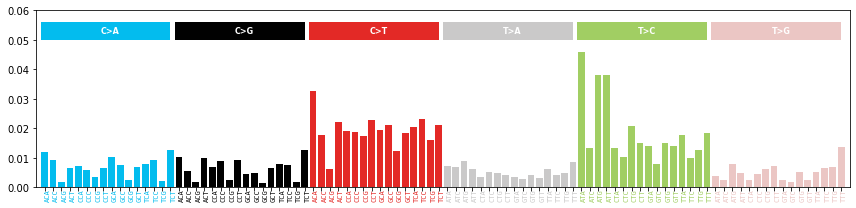

In [4]:
f,ax = plt.subplots(figsize=[12,3])

ax.bar(sbs5.index, sbs5.freq, 
       color=sbs5["sub"].map(palette), width=0.8)

ax.set_xticks(sbs5.index)
ax.set_xticklabels(sbs5.triplet.values,
                   rotation=90,
                   ha="left",
                   va="center",
                   fontsize=7)

for xtick, color in zip(ax.get_xticklabels(), sbs5["sub"].map(palette)):
    xtick.set_color(color)
    xtick.set_fontfamily('monospace')


colors = [palette[s] for s in subs]
maxv = 0.05
height = 0.006
for i,x in enumerate(range(0,95,16)):
    ax.text(x + 7.8, maxv + height/2, subs[i], ha="center", va="center", 
            weight="bold", color="white", fontsize=8)
    print(x,maxv)
    rectangle = Rectangle((x-0.5, maxv), 15.5, height, 
                        facecolor=colors[i])
    ax.add_patch(rectangle)
    center_x, center_y = get_rectangle_center(rectangle)

ax.set_xlim([-1, 96])
ax.set_ylim([0, 0.06])

f.set_facecolor('white')
plt.tight_layout()
#plt.savefig("pdfs/barplot_test.pdf")

Age effect plots

In [5]:
dataset = 'Abascal2021'
filename = '../data/{}/{}-signet.tab'.format(dataset, dataset)
df = pd.read_table(filename)
filename = '../data/{}/{}.tab.gz'.format(dataset, dataset)
dfinfo = pd.read_table(filename)
df = df.merge(dfinfo[['Sample', 'Age', 'Individual']], on='Sample', how='left')
neuron_samples = dfinfo.loc[dfinfo['Tissue_CellType'].str.startswith('Neurons')].Sample
df = df.loc[df['Sample'].isin(neuron_samples)]
df['Dataset'] = dataset
df['Tissue_CellType'] = 'Neurons A'

dataset = 'Ganz2024'
filename = '../data/{}/{}-signet.tab'.format(dataset, dataset)
df2 = pd.read_table(filename)
filename = '../data/{}/{}.tab.gz'.format(dataset, dataset)
dfinfo = pd.read_table(filename)
df2 = df2.merge(dfinfo[['Sample', 'Age', 'Individual']], on='Sample', how='left')
neuron_samples = dfinfo.loc[dfinfo['Tissue_CellType']=='neuron'].Sample
oligo_samples = dfinfo.loc[dfinfo['Tissue_CellType']=='oligo'].Sample
df2['Dataset'] = dataset
df2.loc[df2['Sample'].isin(neuron_samples),'Tissue_CellType'] = 'Neurons B'
df2.loc[df2['Sample'].isin(oligo_samples),'Tissue_CellType'] = 'Oligodendrocytes'
df = pd.concat([df,df2.loc[df2['Sample'].isin(neuron_samples)]],ignore_index=True)
df = pd.concat([df,df2.loc[df2['Sample'].isin(oligo_samples)]],ignore_index=True)
df.reset_index(drop=True, inplace=True)

df3 = pd.read_table('../data/Germline/Germline-signet.tab')
df = pd.concat([df, df3])

ncols = [col for col in df.columns if col.startswith('n')]
df['Number of mutations'] = df[ncols].sum(axis=1)
df['Number of SBS5 mutations'] = df.nSBS5

neurons = df[df.Tissue_CellType.str.contains("Neuron")]
glia = df[df.Tissue_CellType.str.contains("Oligo")].copy()
df3["fSBS5"] = (df3.nSBS5 / df3.NumberOfTrios) 
maternal = df3[df3.Tissue_CellType=="Maternal germline"]
paternal = df3[df3.Tissue_CellType=="Paternal germline"]

In [6]:
neuronsA = neurons[neurons.Dataset=="Abascal2021"].copy()
neuronsG = neurons[neurons.Dataset=="Ganz2024"].copy()
neuronsG["fSBS5"] = neuronsG["nSBS5"] / (1/3) / 2
neuronsA["fSBS5"] = neuronsA["nSBS5"] / (1/3) / 2
glia["fSBS5"] = glia["nSBS5"] / (1/3) / 2

In [7]:
def plot_poisson_fit(ax, data, x_col, y_col, label_prefix, **kwargs):
    # 1. Define the formula
    formula = f"{y_col} ~ {x_col}"

    # 2. Fit the standard Poisson Model using glm()
    poisson_model = smf.glm(formula=formula, data=data, family=sm.families.Poisson())
    poisson_results = poisson_model.fit()

    # 3. Extract model parameters
    slope = poisson_results.params[x_col]
    intercept = poisson_results.params['Intercept']
    p_value = poisson_results.pvalues[x_col]

    # 4. Create the scatter plot
    sns.scatterplot(
        data=data, x=x_col, y=y_col, ax=ax,
        edgecolor=None, alpha=0.7, s=20,
        label="",
        **kwargs
    )

    # 5. Generate points for the exponential fit line
    x_fit = np.linspace(data[x_col].min(), data[x_col].max(), 100)
    # Use np.exp() because the model's output is on the log scale
    y_fit = np.exp(intercept + slope * x_fit)

    # 6. Create the line label
    if p_value < 1e-10:
        line_label = f"{label_prefix}\n$p$<1e-10"
    else:
        line_label = f"{label_prefix}\n$p$={p_value:.1e}"

    # 7. Plot the fit line
    color = kwargs.get('color')
    ax.plot(x_fit, y_fit, label=line_label, color=color)

    return poisson_results

def plot_lme_fit(ax, data, x_col, y_col, group_col, label_prefix, **kwargs):

    formula = f"{y_col} ~ {x_col}"
    lme_model = smf.mixedlm(formula, data=data, groups=data[group_col])
    lme_results = lme_model.fit()

    slope = lme_results.params[x_col]
    intercept = lme_results.params['Intercept']
    p_value = lme_results.pvalues[x_col]

    sns.scatterplot(data=data, x=x_col, y=y_col, ax=ax, 
                    edgecolor=None, alpha=0.8, s=15, 
                    label="",
                    **kwargs)

    x_fit = np.linspace(data[x_col].min(), data[x_col].max(), 100)
    y_fit = intercept + slope * x_fit

    print(label_prefix, slope)

    line_label = f"{label_prefix}\n$p$={p_value:.0e}"
    if p_value<1e-10:
        line_label = f"{label_prefix}\n$p$<1e-10"
    
    color = kwargs.get('color')
    if "Abascal" in label_prefix:
        ax.plot(x_fit, y_fit, label=line_label, linestyle=":", color=color)
    else:
        ax.plot(x_fit, y_fit, label=line_label, color=color)
        ax.annotate(f"{slope:.1f} muts/year", xy=(0.95, 0.05), ha="right",
                    xycoords="axes fraction", color=color)

    return lme_results

def plot_ols_fit(ax, data, x_col, y_col, label_prefix, **kwargs):

    formula = f"{y_col} ~ {x_col}"
    lme_model = smf.ols(formula, data=data)
    ols_results = lme_model.fit()

    slope = ols_results.params[x_col]
    intercept = ols_results.params['Intercept']
    p_value = ols_results.pvalues[x_col]

    sns.scatterplot(data=data, x=x_col, y=y_col, ax=ax, 
                    edgecolor=None, alpha=0.8, s=15, 
                    label="",
                    **kwargs)

    x_fit = np.linspace(data[x_col].min(), data[x_col].max(), 100)
    y_fit = intercept + slope * x_fit

    print(label_prefix, slope)

    line_label = f"{label_prefix}\n$p$={p_value:.0e}"
    if p_value<1e-10:
        line_label = f"{label_prefix}\n$p$<1e-10"
    
    color = kwargs.get('color')
    if "Abascal" in label_prefix:
        ax.plot(x_fit, y_fit, label=line_label, linestyle=":", color=color)
    else:
        ax.plot(x_fit, y_fit, label=line_label, color=color)
        if "Paternal" in label_prefix:
            ax.annotate(f"{slope:.1f} muts/year", xy=(0.95, 0.5), ha="right",
                        xycoords="axes fraction", color=color)
        else:
            ax.annotate(f"{slope:.1f} muts/year", xy=(0.95, 0.05), ha="right",
                        xycoords="axes fraction", color=color)
        if min(x_fit)>10:
            x_fit = np.linspace(0, data[x_col].min(), 100)
            y_fit = intercept + slope * x_fit
            ax.plot(x_fit, y_fit, color=color, alpha=0.3)

    return ols_results


Ganz et al. 10.297140857459004
Abascal et al. 9.607895181403345
Ganz et al. 15.178276472272136


/Users/marc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


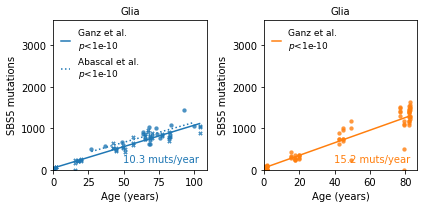

In [10]:
f,axs = plt.subplots(1, 2, figsize=[6,3])
ct_palette = {"neurons":"C0", "glia":"C1"}

# Age effects
ax = axs[0]
#plot_poisson_fit(ax, neuronsG, "Age", "fSBS5", "Ganz et al.", 
#             color=ct_palette["neurons"], marker="X")
plot_lme_fit(ax, neuronsG, "Age", "fSBS5", "Individual", "Ganz et al.", 
             color=ct_palette["neurons"], marker="X")
plot_lme_fit(ax, neuronsA[~neuronsA.Age.isna()], "Age", "fSBS5", "Individual", "Abascal et al.", 
             color=ct_palette["neurons"])
ax.legend(frameon=False, loc="upper left", 
          handlelength=1, fontsize=9)

ax.set_ylabel("SBS5 mutations")
ax.set_xlabel("Age (years)")
ax.set_title("Glia", fontsize=10)
ax.set_xlim(left=0)
ax.set_ylim([0, 3.6e3])

ax = axs[1]
plot_lme_fit(ax, glia, "Age", "fSBS5", "Individual", "Ganz et al.", 
             color=ct_palette["glia"])
ax.legend(frameon=False, loc="upper left", 
          handlelength=1, fontsize=9)

ax.set_ylabel("SBS5 mutations")
ax.set_xlabel("Age (years)")
ax.set_title("Glia", fontsize=10)
ax.set_xlim(left=0)
ax.set_ylim([0, 3.6e3])

plt.tight_layout()

Cosine similarity

In [9]:
observed = df[cosmic.order].values.T
Z = observed.sum(axis=0)
observed = observed / Z

p_of_s = df[signatures].values
p_of_z = np.einsum('ij,kj->ik', cosmic.cosmic[signatures].astype(np.float64).values, p_of_s)

n_times = 1000
simsDenominator = []
ns = df[cosmic.order].values.T.sum(axis=0)
for n, obs in tqdm(zip(ns, observed.T),total=ns.shape[0]):
    simsmean = 0
    for _ in range(n_times):
        zs = np.random.choice(np.arange(96), n, p=obs)
        zs_hist = np.zeros(96)
        for z in zs: zs_hist[z] += 1
        zs_hist = zs_hist / np.sum(zs_hist)
        simsmean += 1-cosine(zs_hist, obs)
    simsmean /= n_times
    simsDenominator.append(simsmean)
simsDenominator = np.array(simsDenominator)

sims = []
for row1, row2 in zip(observed.T, p_of_z.T):
    sims.append(1-cosine(row1, row2))
sims = np.array(sims)
df['Fit'] = sims/simsDenominator

SBS5index = 4
p_of_z_SBS5 = np.einsum('i,k->ik', cosmic.cosmic[signatures].astype(np.float64).values[:,SBS5index], p_of_s[:,SBS5index])
p_of_z_not_SBS5 = p_of_z - p_of_z_SBS5
p_of_z_not_SBS5[p_of_z_not_SBS5<0]=0

observed_sbs5 = observed - p_of_z_not_SBS5

sims_sbs5 = []
sims_sbs3 = []
sims_sbs40 = []
sims_uni = []
for row in observed_sbs5.T:
    sims_sbs5.append(1-cosine(row, cosmic.cosmic.SBS5.values))
    sims_sbs3.append(1-cosine(row, cosmic.cosmic.SBS3.values))
    sims_sbs40.append(1-cosine(row, cosmic.cosmic.SBS40.values))
    sims_uni.append(1-cosine(row, cosmic.cosmic.Count.values))

df['FitSBS5'] = sims_sbs5
df['FitSBS3'] = sims_sbs3
df['FitSBS40'] = sims_sbs40
df['FitUni'] = sims_uni

df["CellType"] = df["Tissue_CellType"].str.split().str[0]

100%|██████████| 180/180 [00:31<00:00,  5.76it/s]


(0.5, 1.0169838379929923)

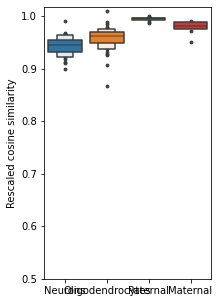

In [10]:
f,ax = plt.subplots(figsize=[3,5])
sdf = df.loc[df['Number of mutations']>=5e2]
sns.boxenplot(data=sdf, x="CellType", y="Fit", flier_kws={"s":8, "marker":"o"})
ax.set_ylabel("Rescaled cosine similarity")
ax.set_xlabel("")
#sns.violinplot(data=sdf, x="CellType", y="Fit")
ax.set_ylim(bottom=0.5)

In [11]:
sdf.groupby("CellType")["Fit"].mean()

CellType
Maternal            0.978110
Neurons             0.943538
Oligodendrocytes    0.956972
Paternal            0.994589
Name: Fit, dtype: float64

In [12]:
df_sbs = df[df["Number of mutations"]>=5e2].melt(id_vars="CellType", value_vars=["FitSBS5", "FitSBS40", "FitSBS3", "FitUni"])
df_sbs.columns = ["CellType", "sign", "cosine"]
df_sbs["sign"] = df_sbs.sign.str.replace("Fit", "").replace("Uni", "Uniform")

(0.5, 1.0302020993489216)

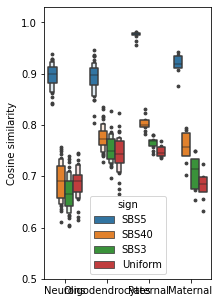

In [13]:
f,ax = plt.subplots(figsize=[3,5])
sns.boxenplot(data=df_sbs, x="CellType", y="cosine", hue="sign", flier_kws={"s":8, "marker":"o"})
ax.set_ylabel("Cosine similarity")
ax.set_xlabel("")
#sns.violinplot(data=sdf, x="CellType", y="Fit")
ax.set_ylim(bottom=0.5)

(0.5, 1.0302020993489216)

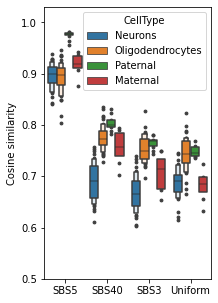

In [14]:
f,ax = plt.subplots(figsize=[3,5])
sns.boxenplot(data=df_sbs, x="sign", y="cosine", hue="CellType", flier_kws={"s":8, "marker":"o"})
ax.set_ylabel("Cosine similarity")
ax.set_xlabel("")
#sns.violinplot(data=sdf, x="CellType", y="Fit")
ax.set_ylim(bottom=0.5)

Barplot

In [15]:
df_sns = df.sort_values(by=["CellType","Number of mutations"], ascending=False).reset_index()
df_sns["non_nSBS5"] = df_sns["Number of mutations"] - df_sns["nSBS5"]
ct_palette = {"neurons":"C0", "glia": "C1", "maternal":"C2", "paternal":"C3"}

Neurons SBS5 frac: 0.8455
Glia SBS5 frac: 0.6209
Maternal SBS5 frac: 0.8250
Paternal SBS5 frac: 0.8604


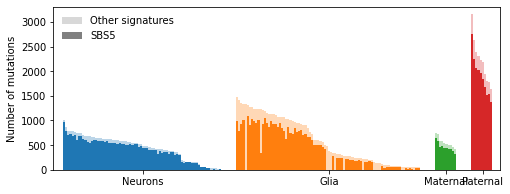

In [16]:
def plot_mutation_summary(df, palette, ax):
    
    # Define the order and mapping of groups to CellType(s) and colors
    plot_groups = [
        ("Neurons", ["Neurons"], palette["neurons"]),
        ("Glia", ["Oligodendrocytes"], palette["glia"]), # Using 'Glia' for label, but 'Oligodendrocytes' for filtering
        ("Maternal", ["Maternal"], palette["maternal"]),
        ("Paternal", ["Paternal"], palette["paternal"]),
    ]

    current_x_offset = 0
    xticks_positions = []
    xtick_labels = []
    x_padding = 7 # Space between groups

    for label, cell_types_filter, color in plot_groups:
        group_df = df[df.CellType.isin(cell_types_filter)].reset_index(drop=True)
        
        if not group_df.empty:
            ax.bar(group_df.index + current_x_offset, group_df["nSBS5"], width=1, color=color)
            ax.bar(group_df.index + current_x_offset, group_df["non_nSBS5"], 
                   color=color, alpha=0.3, width=1, bottom=group_df["nSBS5"])
            
            sbs5_frac = np.mean(group_df["nSBS5"] / group_df["Number of mutations"])
            print(f"{label} SBS5 frac: {sbs5_frac:.4f}")
            
            xticks_positions.append(current_x_offset + len(group_df) / 2)
            xtick_labels.append(label)
            
            current_x_offset += len(group_df) + x_padding
        else:
            print(f"Warning: No data found for '{label}' (CellTypes: {cell_types_filter})")

    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(xtick_labels)
    ax.set_ylabel("Number of mutations")

    legend_handles = [Patch(facecolor='gray', alpha=0.3, label='Other signatures'), 
                      Patch(facecolor='gray', alpha=1, label='SBS5')]
    ax.legend(handles=legend_handles, frameon=False)
    ax.set_xlim([-5, len(df) + (x_padding*3) + 3])


# Call the simplified function
f, ax = plt.subplots(figsize=[8, 3])
plot_mutation_summary(df_sns, ct_palette, ax)

Paternal SBS5 frac: 0.860383193715396
Maternal SBS5 frac: 0.8249522039462986


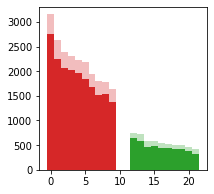

In [17]:
f,ax = plt.subplots(figsize=[3,3])

pat_sns = df_sns[df_sns.CellType=="Paternal"].reset_index(drop=True)
ax.bar(pat_sns.index, pat_sns["nSBS5"], width=1, 
       color=ct_palette["paternal"])
ax.bar(pat_sns.index, pat_sns["non_nSBS5"], 
       color=ct_palette["paternal"], alpha=0.3,width=1,
       bottom = pat_sns["nSBS5"])
print("Paternal SBS5 frac:", np.mean(pat_sns["nSBS5"] / pat_sns["Number of mutations"]))

mat_sns = df_sns[df_sns.CellType=="Maternal"].reset_index(drop=True)
xpad = 2 + len(pat_sns)
ax.bar(mat_sns.index + xpad, mat_sns["nSBS5"], width=1, 
       color=ct_palette["maternal"])
ax.bar(mat_sns.index + xpad, mat_sns["non_nSBS5"], 
       color=ct_palette["maternal"], alpha=0.3,width=1,
       bottom = mat_sns["nSBS5"])
print("Maternal SBS5 frac:", np.mean(mat_sns["nSBS5"] / mat_sns["Number of mutations"]))

Germline

(0.0, 64.13493171852568)

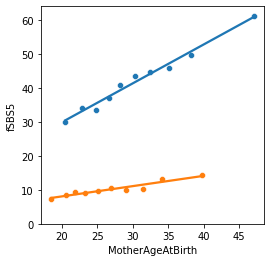

In [18]:
f,ax = plt.subplots(figsize=[4,4])
sns.regplot(data=paternal, x="FatherAgeAtBirth", y="fSBS5", 
            scatter=False, ci=None)
sns.scatterplot(data=paternal, x="FatherAgeAtBirth", y="fSBS5")

sns.regplot(data=maternal, x="MotherAgeAtBirth", y="fSBS5", 
            scatter=False, ci=None)
sns.scatterplot(data=maternal, x="MotherAgeAtBirth", y="fSBS5")
#ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

Figure together

Ganz et al. 10.297140857459004
Abascal et al. 9.607895181403345
Ganz et al. 15.178276472272136
Paternal 1.1447712362307993
Maternal 0.3025460151127549
Neurons SBS5 frac: 0.8455
Glia SBS5 frac: 0.6209


/Users/marc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Maternal SBS5 frac: 0.8250
Paternal SBS5 frac: 0.8604
HEYAA


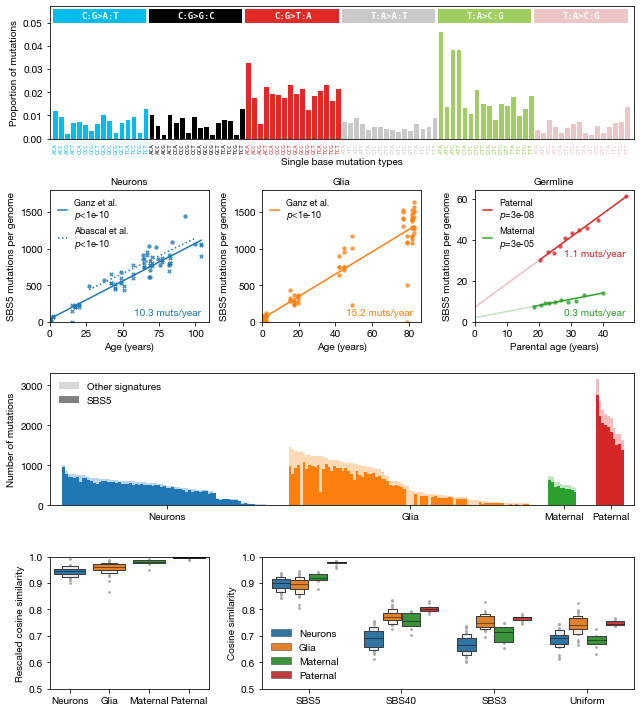

In [22]:
plt.rcParams["font.family"] = "Helvetica Neue"
mosaic = '''
AAAAAAAAA
BBBCCCDDD
EEEEEEEEE
FFFGGGGGG
'''

f, axs = plt.subplot_mosaic(mosaic, 
                            figsize=[9,10])

# SBS5 spectrum
ax = axs["A"]
ax.bar(sbs5.index, sbs5.freq, 
       color=sbs5["sub"].map(palette), width=0.8)

ax.set_xticks(sbs5.index)
ax.set_xticklabels(sbs5.triplet.values,
                   rotation=90,
                   ha="center",
                   va="top",
                   fontsize=6)

for xtick, color in zip(ax.get_xticklabels(), sbs5["sub"].map(palette)):
    xtick.set_color(color)
    xtick.set_fontfamily('monospace')

colors = [palette[s] for s in subs]
maxv = 0.05
height = 0.006
subs_c = ['C:G>A:T', 'C:G>G:C', 'C:G>T:A', 'T:A>A:T', 'T:A>C:G', 'T:A>C:G']

for i,x in enumerate(range(0,95,16)):
    ax.text(x + 7.4, maxv + height/2, subs_c[i], ha="center", va="center", 
            weight="bold", color="white", font="monospace", fontsize=9)
    rectangle = Rectangle((x-0.5, maxv), 15.5, height, 
                        facecolor=colors[i])
    ax.add_patch(rectangle)
    center_x, center_y = get_rectangle_center(rectangle)

ax.set_xlim([-1, 96])
ax.set_ylim([0, 0.057])
ax.set_ylabel("Proportion of mutations")
ax.set_xlabel("Single base mutation types")
ax.tick_params(axis='x', length=0)
f.set_facecolor('white')

# Age effects
ax = axs["B"]
plot_lme_fit(ax, neuronsG, "Age", "fSBS5", "Individual", "Ganz et al.", 
             color=ct_palette["neurons"], marker="X")
plot_lme_fit(ax, neuronsA[~neuronsA.Age.isna()], "Age", "fSBS5", "Individual", "Abascal et al.", 
             color=ct_palette["neurons"])
ax.legend(frameon=False, loc="upper left", 
          handlelength=1, fontsize=9)

ax.set_ylabel("SBS5 mutations per genome")
ax.set_xlabel("Age (years)")
ax.set_title("Neurons", fontsize=10)
ax.set_xlim(left=0)
ax.set_ylim([0, 1.8e3])

ax = axs["C"]
plot_lme_fit(ax, glia, "Age", "fSBS5", "Individual", "Ganz et al.", 
             color=ct_palette["glia"])
ax.legend(frameon=False, loc="upper left", 
          handlelength=1, fontsize=9)

ax.set_ylabel("SBS5 mutations per genome")
ax.set_xlabel("Age (years)")
ax.set_title("Glia", fontsize=10)
ax.set_xlim(left=0)
ax.set_ylim([0, 1.8e3])

ax = axs["D"]
plot_ols_fit(ax, paternal, "FatherAgeAtBirth", "fSBS5", "Paternal", 
             color=ct_palette["paternal"])
plot_ols_fit(ax, maternal, "MotherAgeAtBirth", "fSBS5", "Maternal", 
             color=ct_palette["maternal"])
ax.legend(frameon=False, loc="upper left", 
          handlelength=1, fontsize=9)
ax.set_title("Germline", fontsize=10)
ax.set_ylabel("SBS5 mutations per genome")
ax.set_xlabel("Parental age (years)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Mutation burdens
ax = axs["E"]
plot_mutation_summary(df_sns, ct_palette, ax)

# Boxenplots
ct_palette2 = {"Neurons": ct_palette["neurons"], 
               "Oligodendrocytes":ct_palette["glia"], 
               "Glia":ct_palette["glia"], 
               "Paternal":ct_palette["paternal"], 
               "Maternal":ct_palette["maternal"]}

ax = axs["F"]
print("HEYAA")
sdf = df.loc[df['Number of mutations']>=5e2]
sns.boxenplot(data=sdf, x="CellType", y="Fit", 
              order = ["Neurons", "Oligodendrocytes", "Maternal", "Paternal"],
              flier_kws={"s":3, "marker":"o", "color":"darkgray"}, 
              linewidth=1, line_kws={"color":"black"}, 
              palette = ct_palette2,
              ax=ax)
ax.set_ylabel("Rescaled cosine similarity")
ax.set_xlabel("")
ax.set_xticklabels(["Neurons", "Glia", "Maternal", "Paternal"])
ax.set_ylim([0.5, 1])

ax = axs["G"]
sns.boxenplot(data=df_sbs.replace("Oligodendrocytes", "Glia"), x="sign", y="cosine", hue="CellType", 
              hue_order = ["Neurons", "Glia", "Maternal", "Paternal"],
              linewidth=1,line_kws={"color":"black"}, 
              palette = ct_palette2,
              flier_kws={"s":3, "marker":"o", "color":"darkgray"})

ax.legend(title="", frameon=False)
ax.set_xlabel("")
ax.set_ylabel("Cosine similarity")
ax.set_xlabel("")
ax.set_ylim([0.5, 1])

plt.tight_layout()
#plt.savefig("pdfs/fig1.pdf")
#plt.savefig("pdfs/fig1.jpg", dpi=400)

In [33]:
5/(2/5)

12.5

Ganz et al. 10.297140857459004
Abascal et al. 9.607895181403345
Ganz et al. 15.178276472272136
Paternal 1.1447712362307993
Maternal 0.3025460151127549
Neurons SBS5 frac: 0.8455


/Users/marc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Glia SBS5 frac: 0.6209
Maternal SBS5 frac: 0.8250
Paternal SBS5 frac: 0.8604


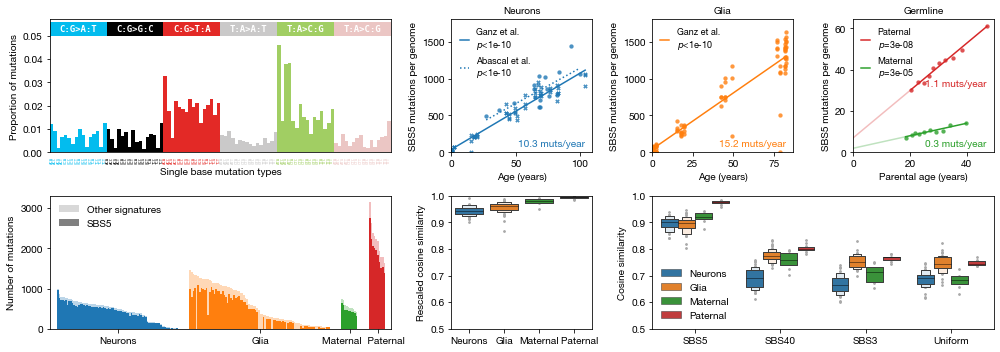

In [63]:
plt.rcParams["font.family"] = "Helvetica Neue"
mosaic = '''
AABCD
EEFGG
'''

f, axs = plt.subplot_mosaic(mosaic, 
                            figsize=[14,5])

# SBS5 spectrum
ax = axs["A"]
ax.bar(sbs5.index, sbs5.freq, 
       color=sbs5["sub"].map(palette), width=1)

ax.set_xticks(sbs5.index)
ax.set_xticklabels(sbs5.triplet.values,
                   rotation=90,
                   ha="center",
                   va="top",
                   fontsize=4)

for xtick, color in zip(ax.get_xticklabels(), sbs5["sub"].map(palette)):
    xtick.set_color(color)
    xtick.set_fontfamily('monospace')

colors = [palette[s] for s in subs]
maxv = 0.05
height = 0.006
subs_c = ['C:G>A:T', 'C:G>G:C', 'C:G>T:A', 'T:A>A:T', 'T:A>C:G', 'T:A>C:G']

for i,x in enumerate(range(-1,95,16)):
    x += 0.5
    ax.text(x + 8, maxv + height/2, subs_c[i], ha="center", va="center", 
            weight="bold", color="white", font="monospace", fontsize=9)
    rectangle = Rectangle((x, maxv), 16, height, 
                        facecolor=colors[i], edgecolor="none")
    ax.add_patch(rectangle)
    center_x, center_y = get_rectangle_center(rectangle)

ax.set_xlim([-0.5, 95.5])
ax.set_ylim([0, 0.057])
ax.set_ylabel("Proportion of mutations")
ax.set_xlabel("Single base mutation types")
ax.tick_params(axis='x', length=0)
f.set_facecolor('white')

# Age effects
ax = axs["B"]
plot_lme_fit(ax, neuronsG, "Age", "fSBS5", "Individual", "Ganz et al.", 
             color=ct_palette["neurons"], marker="X")
plot_lme_fit(ax, neuronsA[~neuronsA.Age.isna()], "Age", "fSBS5", "Individual", "Abascal et al.", 
             color=ct_palette["neurons"])
ax.legend(frameon=False, loc="upper left", 
          handlelength=1, fontsize=9)

ax.set_ylabel("SBS5 mutations per genome")
ax.set_xlabel("Age (years)")
ax.set_title("Neurons", fontsize=10)
ax.set_xlim(left=0)
ax.set_ylim([0, 1.8e3])

ax = axs["C"]
plot_lme_fit(ax, glia, "Age", "fSBS5", "Individual", "Ganz et al.", 
             color=ct_palette["glia"])
ax.legend(frameon=False, loc="upper left", 
          handlelength=1, fontsize=9)

ax.set_ylabel("SBS5 mutations per genome")
ax.set_xlabel("Age (years)")
ax.set_title("Glia", fontsize=10)
ax.set_xlim(left=0)
ax.set_ylim([0, 1.8e3])

ax = axs["D"]
plot_ols_fit(ax, paternal, "FatherAgeAtBirth", "fSBS5", "Paternal", 
             color=ct_palette["paternal"])
plot_ols_fit(ax, maternal, "MotherAgeAtBirth", "fSBS5", "Maternal", 
             color=ct_palette["maternal"])
ax.legend(frameon=False, loc="upper left", 
          handlelength=1, fontsize=9)
ax.set_title("Germline", fontsize=10)
ax.set_ylabel("SBS5 mutations per genome")
ax.set_xlabel("Parental age (years)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Mutation burdens
ax = axs["E"]
plot_mutation_summary(df_sns, ct_palette, ax)
ax.set_xticklabels(["Neurons", "Glia", "Maternal      ", "      Paternal"])

# Boxenplots
ct_palette2 = {"Neurons": ct_palette["neurons"], 
               "Oligodendrocytes":ct_palette["glia"], 
               "Glia":ct_palette["glia"], 
               "Paternal":ct_palette["paternal"], 
               "Maternal":ct_palette["maternal"]}

ax = axs["F"]
sdf = df.loc[df['Number of mutations']>=5e2]
sns.boxenplot(data=sdf, x="CellType", y="Fit", 
              order = ["Neurons", "Oligodendrocytes", "Maternal", "Paternal"],
              flier_kws={"s":3, "marker":"o", "color":"darkgray"}, 
              linewidth=1, line_kws={"color":"black"}, 
              palette = ct_palette2,
              ax=ax)
ax.set_ylabel("Rescaled cosine similarity")
ax.set_xlabel("")
ax.set_xticklabels(["Neurons", "Glia", "Maternal", "    Paternal"])
ax.set_ylim([0.5, 1])

ax = axs["G"]
sns.boxenplot(data=df_sbs.replace("Oligodendrocytes", "Glia"), x="sign", y="cosine", hue="CellType", 
              hue_order = ["Neurons", "Glia", "Maternal", "Paternal"],
              linewidth=1,line_kws={"color":"black"}, 
              palette = ct_palette2,
              flier_kws={"s":3, "marker":"o", "color":"darkgray"})

ax.legend(title="", frameon=False)
ax.set_xlabel("")
ax.set_ylabel("Cosine similarity")
ax.set_xlabel("")
ax.set_ylim([0.5, 1])

plt.tight_layout()
plt.savefig("pdfs/fig1_v2.pdf")
plt.savefig("pdfs/fig1_v2.jpg", dpi=400)

Ganz et al. 6.864760571639344
Abascal et al. 6.405263454268897
Ganz et al. 10.118850981514747


/Users/marc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


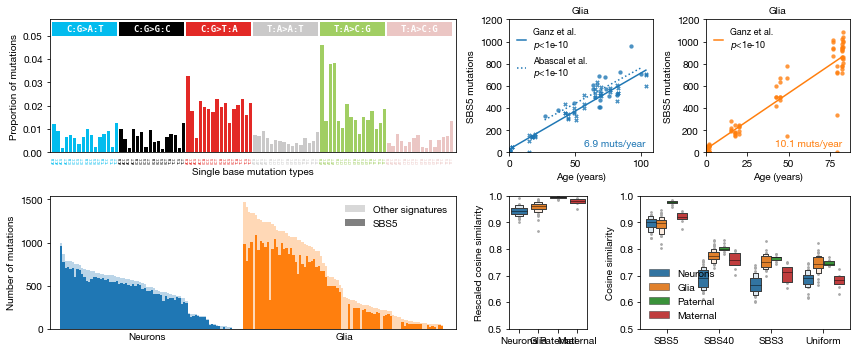

In [339]:
plt.rcParams["font.family"] = "Helvetica Neue"
mosaic = '''
AAAAAAABBBCCC
FFFFFFFDDEEEE
'''
f, axs = plt.subplot_mosaic(mosaic, 
                            figsize=[12,5])

ct_palette = {"neurons":"C0", "glia": "C1", "paternal":"C2", "maternal":"C3"}

# SBS5 spectrum
ax = axs["A"]
ax.bar(sbs5.index, sbs5.freq, 
       color=sbs5["sub"].map(palette), width=0.8)

ax.set_xticks(sbs5.index)
ax.set_xticklabels(sbs5.triplet.values,
                   rotation=90,
                   ha="center",
                   va="top",
                   fontsize=4)

for xtick, color in zip(ax.get_xticklabels(), sbs5["sub"].map(palette)):
    xtick.set_color(color)
    xtick.set_fontfamily('monospace')

colors = [palette[s] for s in subs]
maxv = 0.05
height = 0.006
subs_c = ['C:G>A:T', 'C:G>G:C', 'C:G>T:A', 'T:A>A:T', 'T:A>C:G', 'T:A>C:G']

for i,x in enumerate(range(0,95,16)):
    ax.text(x + 7.4, maxv + height/2, subs_c[i], ha="center", va="center", 
            weight="bold", color="white", font="monospace", fontsize=9)
    rectangle = Rectangle((x-0.5, maxv), 15.5, height, 
                        facecolor=colors[i])
    ax.add_patch(rectangle)
    center_x, center_y = get_rectangle_center(rectangle)

ax.set_xlim([-1, 96])
ax.set_ylim([0, 0.057])
ax.set_ylabel("Proportion of mutations")
ax.set_xlabel("Single base mutation types")
ax.tick_params(axis='x', length=0)
f.set_facecolor('white')

# Mutation burdens
ax = axs["F"]
neurons_sns = df_sns[df_sns.CellType=="Neurons"].reset_index(drop=True)
ax.bar(neurons_sns.index, neurons_sns["nSBS5"], 
       color=ct_palette["neurons"], width=1)
ax.bar(neurons_sns.index, neurons_sns["non_nSBS5"], 
       color=ct_palette["neurons"], alpha=0.3, width=1,
       bottom = neurons_sns["nSBS5"])

glia_sns = df_sns[df_sns.CellType=="Oligodendrocytes"].reset_index(drop=True)
xpad = 5 + len(neurons_sns)
ax.bar(glia_sns.index + xpad, glia_sns["nSBS5"],
       color=ct_palette["glia"], width=1)
ax.bar(glia_sns.index + xpad, glia_sns["non_nSBS5"], 
       color=ct_palette["glia"], alpha=0.3,width=1,
       bottom = glia_sns["nSBS5"])

ax.set_xticks([len(neurons_sns)/2, 
               len(glia_sns)/2 + xpad])
ax.set_xticklabels(["Neurons", "Glia"])

legend_handles = [Patch(facecolor='gray', alpha=0.3, label='Other signatures'), 
                  Patch(facecolor='gray', alpha=1, label='SBS5')]

ax.legend(handles=legend_handles, frameon=False)
ax.tick_params(axis='x', length=0)
ax.set_xlim([-5, len(glia_sns) + xpad + 5])
ax.set_ylabel("Number of mutations")

# Age effects
ax = axs["B"]
plot_lme_fit(ax, neuronsG, "Age", "nSBS5", "Individual", "Ganz et al.", 
             color=ct_palette["neurons"], marker="X")
plot_lme_fit(ax, neuronsA[~neuronsA.Age.isna()], "Age", "nSBS5", "Individual", "Abascal et al.", 
             color=ct_palette["neurons"])
ax.legend(frameon=False, loc="upper left", 
          handlelength=1, fontsize=9)

ax.set_ylabel("SBS5 mutations")
ax.set_xlabel("Age (years)")
ax.set_title("Glia", fontsize=10)
ax.set_xlim(left=0)
ax.set_ylim([0, 1.2e3])

ax = axs["C"]
plot_lme_fit(ax, glia, "Age", "nSBS5", "Individual", "Ganz et al.", 
             color=ct_palette["glia"])
ax.legend(frameon=False, loc="upper left", 
          handlelength=1, fontsize=9)

ax.set_ylabel("SBS5 mutations")
ax.set_xlabel("Age (years)")
ax.set_title("Glia", fontsize=10)
ax.set_xlim(left=0)
ax.set_ylim([0, 1.2e3])

# Boxen plots
ct_palette2 = {"Neurons": ct_palette["neurons"], 
               "Oligodendrocytes":ct_palette["glia"], 
               "Glia":ct_palette["glia"], 
               "Paternal":ct_palette["paternal"], 
               "Maternal":ct_palette["maternal"]}
ax = axs["D"]
sdf = df.loc[df['Number of mutations']>=5e2]
sns.boxenplot(data=sdf, x="CellType", y="Fit", 
              flier_kws={"s":3, "marker":"o", "color":"darkgray"}, 
              linewidth=1, line_kws={"color":"black"}, 
              palette = ct_palette2,
              ax=ax)
ax.set_ylabel("Rescaled cosine similarity")
ax.set_xlabel("")
ax.set_xticklabels(["Neurons", "Glia", "Paternal", "Maternal"])
ax.set_ylim([0.5, 1])

ax = axs["E"]

# cell_type_order = df_sbs["CellType"].unique()
# for ct in cell_type_order:
#     ctdf = df_sbs[df_sbs["CellType"] == ct]
    
#     sns.boxenplot(
#         data=ctdf, 
#         x="CellType", # Use the column name directly
#         y="cosine", 
#         hue="sign",
#         order=cell_type_order, # <-- This forces the correct position
#         flier_kws={"s": 8, "marker": "o"},
#         linewidth=1,
#         ax=ax,
#         palette={h: ct_palette2.get(ct) for h in ctdf["sign"].unique()}
#     )

#     if ct=="Neurons":
#         pos = 0.25
#         xs = np.linspace(0-pos, 0+pos, 3)
#         for i2,sig in enumerate(["SBS5", "SBS40", "SBS3"]):
#             sigdf = ctdf[ctdf.sign==sig]
#             minv = sigdf.cosine.min()
#             print(sig, xs[i2])
#             ax.text(xs[i2], minv-0.005, sig, 
#                     rotation=90, ha="left", va="top")

sns.boxenplot(data=df_sbs.replace("Oligodendrocytes", "Glia"), x="sign", y="cosine", hue="CellType", 
              linewidth=1,line_kws={"color":"black"}, 
              palette = ct_palette2,
              flier_kws={"s":3, "marker":"o", "color":"darkgray"})

ax.legend(title="", frameon=False)
ax.set_xlabel("")
ax.set_ylabel("Cosine similarity")
ax.set_xlabel("")
ax.set_ylim([0.5, 1])

plt.tight_layout()
#plt.savefig("pdfs/fig1_alt.pdf")
#plt.savefig("pdfs/fig1_alt.jpg", dpi=400)